<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/toxic_%EC%88%98%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize, sent_tokenize #word:don't->do, n't // Jone's->Jone, 's #sent:여러개의 문장들->문장 구분
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

Mounted at /content/drive


## 1.데이터 불러오기

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/2021-1 parrot project/TOXIC P/dataset_toxic/train.csv")
columns = list(train.columns)
columns = columns[2:]
columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
train.loc[train["toxic"]==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/2021-1 parrot project/TOXIC P/dataset_toxic/sample_submission.csv")
sample_submission.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/2021-1 parrot project/TOXIC P/dataset_toxic/test.csv")
test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels = pd.read_csv("/content/drive/MyDrive/2021-1 parrot project/TOXIC P/dataset_toxic/test_labels.csv")
test_labels.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


# 2.EDA

In [ ]:
print('훈련용 리뷰 개수 :',len(train)) 

훈련용 리뷰 개수 : 159571


In [ ]:
X_train = train.comment_text
y_train = train[["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]].values
X_test = test.comment_text

In [ ]:
y_train[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
X_train.head(5)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [ ]:
print('toxic: %d' % train[train['toxic'] > 0]['toxic'].count())
print('severe_toxic: %d' % train[train['severe_toxic'] > 0]['severe_toxic'].count())
print('obscene: %d' % train[train['obscene'] > 0]['obscene'].count())
print('threat: %d' % train[train['threat'] > 0]['threat'].count())
print('insult: %d' % train[train['insult'] > 0]['insult'].count())
print('identity_hate: %d' % train[train['identity_hate'] > 0]['identity_hate'].count())

toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405


In [ ]:
train['len'] = train['comment_text'].str.len()
print('Average comment length: %d' % train['len'].mean())
print('Median comment length: %d' % train['len'].quantile(.5))
print('90th percentile comment length: %d' % train['len'].quantile(.9))

Average comment length: 394
Median comment length: 205
90th percentile comment length: 889


# 3.Preprocessing(토큰화, 정제, 정규화, 불용어 제거)

In [ ]:
#데이터 중복 확인
train['comment_text'].nunique()

159571

In [ ]:
#Null 값 확인
print(train.isnull().values.any())

False


In [ ]:
#기존 preprocessing

def text_to_words(raw_text, remove_stopwords=False):
    # 1. Remove non-letters, but including numbers
    letters_only = re.sub("[^0-9a-zA-Z]", " ", raw_text)
    

    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english")) # In Python, searching a set is much faster than searching
        meaningful_words = [w for w in words if not w in stops] # Remove stop words
        words = meaningful_words
    return words 

sentences_train = train['comment_text'].apply(text_to_words, remove_stopwords=False)
sentences_test = test['comment_text'].apply(text_to_words, remove_stopwords=False)

print(sentences_train[:20])

In [ ]:
#preprocessing

def text_to_words(raw_text, remove_stopwords=False):
    # 1. Remove non-letters, but including numbers
    letters_only = re.sub("[^0-9a-zA-Z]", " ", raw_text) #영어, 숫자만
    short=re.sub(r'\W*\b\w{1,2}\b'," ",letters_only) #불필요한(의미없는) 단어 제거(1~2길이 단어 제거)
    

    # 2. Convert to lower case, split into individual words
    words = short.lower().split() 
    if remove_stopwords:
        stops = set(stopwords.words("english")) # In Python, searching a set is much faster than searching
        meaningful_words = [w for w in words if not w in stops] # 불용어 제거
        words = meaningful_words
    return words 

X_train = train['comment_text'].apply(text_to_words, remove_stopwords=False)
X_test = test['comment_text'].apply(text_to_words, remove_stopwords=False)

print(X_train[:20])

0     [explanation, why, the, edits, made, under, us...
1     [aww, matches, this, background, colour, seemi...
2     [hey, man, really, not, trying, edit, war, jus...
3     [more, can, make, any, real, suggestions, impr...
4     [you, sir, are, hero, any, chance, you, rememb...
5     [congratulations, from, well, use, the, tools,...
6         [cocksucker, before, you, piss, around, work]
7     [your, vandalism, the, matt, shirvington, arti...
8     [sorry, the, word, nonsense, was, offensive, y...
9     [alignment, this, subject, and, which, are, co...
10    [fair, use, rationale, for, image, wonju, jpg,...
11    [bbq, man, and, lets, discuss, maybe, over, th...
12    [hey, what, talk, what, exclusive, group, some...
13    [before, you, start, throwing, accusations, an...
14    [and, the, girl, above, started, her, argument...
15    [juelz, santanas, age, 2002, juelz, santana, w...
16    [bye, don, look, come, think, comming, back, t...
17    [redirect, talk, voydan, pop, georgiev, ch

In [ ]:
#정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 빈도수가 낮은 단어들은 자연어 처리에서 배제
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 181189
등장 빈도가 2번 이하인 희귀 단어의 수: 119936
단어 집합에서 희귀 단어의 비율: 66.19386386590797
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.742837666898735


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 61254


In [ ]:
#텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[617, 51, 1, 99, 102, 145, 607, 4240, 10989, 1000, 60, 290, 27, 2076, 10990, 31, 6553, 38, 2557, 119, 2734, 91, 1096, 14608, 2603, 2, 26, 36, 206, 1, 319, 17, 1, 19, 16, 115, 3152, 63, 4306], [15839, 2443, 6, 499, 3558, 4291, 2521, 11, 68, 19, 894, 7874, 149], [362, 372, 106, 7, 212, 50, 270, 31, 4, 6, 539, 2115, 440, 451, 76, 2, 547, 284, 99, 318, 19, 16, 176, 384, 37, 20, 1, 2211, 67, 1, 664, 416]]


In [ ]:
y_train = np.array(y_train)
#y_test = np.array()

In [ ]:
#빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거(없음)
X_train = np.delete(X_train, drop_train, axis=0)
#y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
#print(len(y_train))

comment_text의 최대 길이 : 1250
commnet_text의 평균 길이 : 51.64301157478489


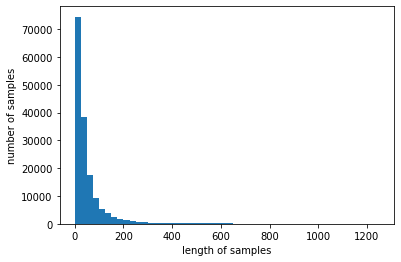

In [ ]:
#패딩
print('comment_text의 최대 길이 :',max(len(l) for l in X_train))
print('commnet_text의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 150
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 150 이하인 샘플의 비율: 93.36972256863716


In [ ]:
#모든 샘플의 길이를 150으로 맞춤
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
print(X_train.shape)
print(X_test.shape)


(159571, 150)
(153164, 150)


In [ ]:
num_words = 20000
max_len = 150
emb_size = 128

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
input = Input(shape = (max_len,))
layer = Embedding(num_words,emb_size)(input) #num_words의 단어를 emb_size로 벡터화
layer = Bidirectional(LSTM(50,return_sequences=True,recurrent_dropout=0.15))(layer) #return_sequences : 레이어를 여러 개 쌓아 올릴 때
# recurrent_dropout : 현재 Input에 영향을 받는 Parameter에만 Dropout을 적용하는 것
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50,activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(6,activation = 'sigmoid')(layer)
model = Model(inputs = input, outputs=layer)
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 128)          2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 100)          71600     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
#preprocessing 2
def text_to_words(raw_text):
    # 1. Remove non-letters, but including numbers
    raw_text = re.sub("[^0-9a-zA-Z]", " ", raw_text) #영어, 숫자만
    raw_text = re.sub(r'\W*\b\w{1,2}\b'," ",raw_text) #불필요한(의미없는) 단어 제거(1~2길이 단어 제거)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.corpus import stopwords  
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [ ]:
# 토큰화 #불용어 제거
from tensorflow.keras.preprocessing.text import text_to_word_sequence

X_train = []
for sentence in train['comment_text']:
    temp_X = text_to_word_sequence(temp_X) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

KeyError: ignored

In [ ]:
X_train = 
y_train = 
X_test = test.comment_text

In [ ]:
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['preprocess'] = train.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1) #removes new line character
test['preprocess'] = test.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1)

#removes urls
train['preprocess']=train.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)

#remove all non-alphanumeric values(Except single quotes)
train['preprocess']=train.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)

#remove stopwords as they occupy major chunk of the vocabulary
train['preprocess'] = train['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['preprocess'] = test['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removes all additional spaces
train['preprocess']=train.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)
#https://www.kaggle.com/sasidharturaga/eda-step-wise-preprocess-and-lstm-classifier

# 3.W2V

Word2Vec 모델 1(model)

In [ ]:
from gensim.models import word2vec
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
# Initialize and train the model 
model = word2vec.Word2Vec(sentences_train, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)
model.init_sims(replace=True) # marks the end of training to speed up the use of the model(필요없는 메모리 unload)
#model = gensim.models.Word2Vec(iter=1, min_count=5)
#size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
#window = 컨텍스트 윈도우 크기
#min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
#workers = 학습을 위한 프로세스 수
#sg = 0은 CBOW, 1은 Skip-gram.

In [ ]:
vectors = model.wv
#del model

In [ ]:
vectors['good']


array([ 4.05162983e-02, -8.71024802e-02, -7.61475191e-02,  4.17969637e-02,
       -2.51455661e-02,  5.37620299e-02, -7.50558004e-02,  3.74311432e-02,
       -3.64701822e-02,  4.41822596e-02,  5.03319576e-02, -1.80146173e-02,
       -2.47544236e-02,  1.78050734e-02, -1.49769075e-02, -5.42766042e-02,
        4.15359624e-02, -5.26966807e-03, -7.32954592e-03, -4.98701073e-02,
       -8.09885841e-03,  3.94709148e-02, -4.15089540e-02, -6.69024047e-03,
        2.32009552e-02,  5.40364683e-02, -5.51157212e-03,  6.84705451e-02,
       -9.22702998e-02, -1.18233517e-01, -6.29208535e-02, -8.41974374e-03,
       -2.39799600e-02, -3.51625457e-02,  1.56299230e-02,  9.94248874e-03,
        1.18854344e-01,  1.00253923e-02,  1.37081698e-01,  5.03376424e-02,
        6.01260439e-02,  1.60821155e-01,  4.99149822e-02,  1.16240596e-02,
        7.73984566e-02, -1.12584131e-02, -3.99333760e-02,  1.83403715e-02,
       -1.26908785e-02,  1.86943896e-02,  2.72952691e-02, -5.61766420e-03,
       -7.96805099e-02, -

In [ ]:
model_result1 = model.wv.most_similar("good")
print(model_result1)

[('bad', 0.705236554145813), ('nice', 0.524634063243866), ('great', 0.43744146823883057), ('terrible', 0.4244636595249176), ('poor', 0.41128724813461304), ('fine', 0.40439271926879883), ('better', 0.39479655027389526), ('decent', 0.35686445236206055), ('useful', 0.3566397726535797), ('helpful', 0.35612648725509644)]


In [ ]:
model.wv.vectors.shape

(11250, 300)

In [ ]:
embedding_matrix_w2vc = np.zeros((vocab_size, 300))
np.shape(embedding_matrix_w2vc)

(190060, 300)

In [ ]:
def get_vector(word):
    if word in model.wv:
        return model.wv[word]
    else:
        return None

In [ ]:
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)  # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    if temp is not None : # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix_w2vc[i] = temp

NameError: ignored

In [ ]:
model_result2 = model.wv.most_similar("war")
print(model_result2)

[('wars', 0.704084038734436), ('warring', 0.5758286714553833), ('warred', 0.5712268352508545), ('battle', 0.5578720569610596), ('invasion', 0.5347889065742493), ('wwii', 0.5132366418838501), ('victory', 0.4959246516227722), ('iraq', 0.48020192980766296), ('army', 0.4778652787208557), ('conflicts', 0.4700937867164612)]


In [ ]:
model_result3 = model.wv.most_similar("fuck")
print(model_result3)

[('cunt', 0.6021218299865723), ('fucking', 0.5642269849777222), ('fuckin', 0.5507758855819702), ('bitch', 0.5249624252319336), ('shit', 0.5185149908065796), ('motherfucker', 0.5167473554611206), ('hell', 0.5121530294418335), ('ass', 0.5093834400177002), ('damn', 0.5087145566940308), ('shitty', 0.4960164725780487)]


In [ ]:
model_result4 = model.wv.most_similar("explanation")
print(model_result4)

[('justification', 0.6364733576774597), ('rationale', 0.5308720469474792), ('reason', 0.49440914392471313), ('indication', 0.47945696115493774), ('outline', 0.4675516188144684), ('objection', 0.46657252311706543), ('argument', 0.4611869752407074), ('reasoning', 0.43700283765792847), ('reasons', 0.43660852313041687), ('context', 0.4362267553806305)]


In [ ]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
#loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [ ]:
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [ ]:
model_result5 = loaded_model.most_similar("war")
print(model_result5)

[('wars', 0.6803454160690308), ('warring', 0.5769931077957153), ('battle', 0.5550742745399475), ('warred', 0.5338819026947021), ('invasion', 0.5066319108009338), ('victory', 0.4874706268310547), ('army', 0.4848262071609497), ('wwii', 0.4671473503112793), ('soviet', 0.45776572823524475), ('iraq', 0.4575268030166626)]


embedding vector to model?(https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) 방법 찾기

In [ ]:
import numpy as np
import gensim
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('eng_w2v', binary=True)  

In [ ]:
print(word2vec_model.vectors.shape)# 모델의 크기 확인

(8165, 300)


In [ ]:
#300의 차원을 가진 Word2Vec 벡터가 8210개 있음..?

In [ ]:
vocab_size=len(sentences_train)
vocab_size

159571

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
# 단어 집합 크기의 행과 300개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)

(159571, 300)

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
for word, i in sentences_train.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Embedding Layer 방법 찾기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
max_len=150
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=True)

In [ ]:
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

ValueError: ignored

In [ ]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [ ]:
model_result5 = loaded_model.most_similar("war")
print(model_result5)

[('wars', 0.7109693288803101), ('warring', 0.5761391520500183), ('battle', 0.5750802159309387), ('warred', 0.5735384225845337), ('victory', 0.5078235864639282), ('army', 0.5007004737854004), ('wwii', 0.4778203070163727), ('invasion', 0.4759833514690399), ('iraq', 0.472567081451416), ('warrior', 0.461758553981781)]


In [ ]:
model.similarity('sock', 'toxic')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.0068683233

Word2Vec 모델 2(model2)

In [ ]:
from gensim.models import word2vec
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
# Initialize and train the model (this will take some time)
model2 = word2vec.Word2Vec(sentences_train, size=100, window=5, min_count=5, workers=4, sg=1)
model2.init_sims(replace=True) # marks the end of training to speed up the use of the model(필요없는 메모리 unload)
#model = gensim.models.Word2Vec(iter=1, min_count=5)
#size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
#window = 컨텍스트 윈도우 크기
#min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
#workers = 학습을 위한 프로세스 수
#sg = 0은 CBOW, 1은 Skip-gram.

In [ ]:
model2_result6 = model2.wv.most_similar("good")
print(model2_result6)

[('nice', 0.7333452105522156), ('bad', 0.7260962724685669), ('superb', 0.6809818148612976), ('faith', 0.679627537727356), ('brilliant', 0.6740128993988037), ('luck', 0.6657828092575073), ('decent', 0.6600880026817322), ('fantastic', 0.6519118547439575), ('swell', 0.646277904510498), ('natured', 0.6327653527259827)]


In [ ]:
model2_result7 = model2.wv.most_similar("war")
print(model2_result7)

[('wars', 0.7387489676475525), ('wwii', 0.6697685718536377), ('punic', 0.6681240200996399), ('falklands', 0.6664019823074341), ('waging', 0.6646537780761719), ('napoleonic', 0.6543854475021362), ('1812', 0.6528611183166504), ('battle', 0.6519602537155151), ('sparked', 0.6470191478729248), ('wwi', 0.6465203762054443)]


In [ ]:
model2_result8 = model2.wv.most_similar("fuck")
print(model2_result8)

[('supressing', 0.7694493532180786), ('facists', 0.7684067487716675), ('misterwiki', 0.7493607997894287), ('niggas', 0.7447677254676819), ('fuk', 0.7409355044364929), ('bitches', 0.7389950752258301), ('suk', 0.73809415102005), ('sod', 0.7254297137260437), ('shitty', 0.7244499921798706), ('fcuk', 0.7225721478462219)]


In [ ]:
from gensim.models import KeyedVectors
model2.wv.save_word2vec_format('eng2_w2v') # 모델 저장
loaded_model2 = KeyedVectors.load_word2vec_format("eng2_w2v") # 모델 로드

Word2Vec 모델 3(model3)

In [ ]:
from gensim.models import word2vec
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
# Initialize and train the model (this will take some time)
model3 = word2vec.Word2Vec(sentences_train, size=100, window=5, min_count=5, workers=4, sg=0)
model3.init_sims(replace=True) # marks the end of training to speed up the use of the model(필요없는 메모리 unload)
#model = gensim.models.Word2Vec(iter=1, min_count=5)
#size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
#window = 컨텍스트 윈도우 크기
#min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
#workers = 학습을 위한 프로세스 수
#sg = 0은 CBOW, 1은 Skip-gram.

In [ ]:
model3_result9 = model3.wv.most_similar("war")
print(model3_result9)

[('wars', 0.7616546750068665), ('warring', 0.6635650396347046), ('battle', 0.6515286564826965), ('warred', 0.6063735485076904), ('conflicts', 0.5463763475418091), ('summaries', 0.5361846685409546), ('thon', 0.5360012650489807), ('invasion', 0.5324710011482239), ('army', 0.5272731781005859), ('summary', 0.5255724787712097)]


In [ ]:
from gensim.models import KeyedVectors
model3.wv.save_word2vec_format('eng3_w2v') # 모델 저장
loaded_model3 = KeyedVectors.load_word2vec_format("eng3_w2v") # 모델 로드

# 4.GloVe

GloVe

In [ ]:
!pip install glove_python_binary

     |████████████████████████████████| 952kB 7.5MB/s 


In [ ]:
from glove import Corpus, Glove

In [ ]:
corpus = Corpus() 
corpus.fit(sentences_train, window=5)
# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성

glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [ ]:
model10=glove.most_similar("good")
print(model10)

[('faith', 0.8247972873627928), ('job', 0.8120741715616953), ('luck', 0.8112106903027019), ('idea', 0.7627503518200783)]


In [ ]:
model11=glove.most_similar("war")
print(model11)

[('2008georgia', 0.8764123279736562), ('ii', 0.8563759568104301), ('criminalwar', 0.8475772772073239), ('cold', 0.8221995082170612)]


In [ ]:
model12=glove.most_similar("fuck")
print(model12)

[('fuckity', 0.9545293112568916), ('uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu', 0.9294739596081624), ('misterwiki', 0.9209461940470126), ('yourselfgo', 0.9129870378639713)]


FastText

In [ ]:
from gensim.models import FastText
ft_model = FastText(sentences_train, size=100, window=5, min_count=5, workers=4, sg=1)

In [ ]:
model2_result = ft_model.wv.most_similar("explanation")
print(model2_result)

[('explanations', 0.9122016429901123), ('explanatory', 0.888404369354248), ('explaning', 0.8416481018066406), ('justification', 0.7587119340896606), ('explaination', 0.7326990365982056), ('alteration', 0.7067852020263672), ('edification', 0.7040871381759644), ('ration', 0.6963322758674622), ('explination', 0.6893163919448853), ('justifications', 0.6858721971511841)]


In [ ]:
model3_result = ft_model.wv.most_similar("war")
print(model3_result)

[('wars', 0.7554676532745361), ('warzone', 0.7221353650093079), ('warsaw', 0.6897923946380615), ('battle', 0.6818721294403076), ('wart', 0.6776053309440613), ('wwii', 0.6757681369781494), ('warring', 0.6752650737762451), ('wartime', 0.6540999412536621), ('battlefield', 0.6531223058700562), ('ww1', 0.6527427434921265)]


### 4. 모델

##### 1. BiLSTM

In [ ]:
input = Input(shape = (max_len,))
layer = Embedding(num_words,emb_size)(input) #num_words의 단어를 emb_size로 벡터화
layer = Bidirectional(LSTM(50,return_sequences=True,recurrent_dropout=0.15))(layer) #return_sequences : 레이어를 여러 개 쌓아 올릴 때
# recurrent_dropout : 현재 Input에 영향을 받는 Parameter에만 Dropout을 적용하는 것
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50,activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(6,activation = 'sigmoid')(layer)
model = Model(inputs = input, outputs=layer)
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 120)          2400000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          68400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
hist = model.fit(X,y,batch_size=32, epochs=2, validation_split = 0.2, callbacks= [checkpoint,early_stop])

NameError: ignored

In [ ]:
model.save('toxic1_model1',save_format='tf')

##### 2. GRU

In [ ]:
def bm_gru(num_words, emb):
    input = Input(shape=(max_len,))
    x = Embedding(num_words, emb)(input)
    x = GRU(128)(x)
    x = Dropout(0.2)(x)
    x = Dense(50,activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(6,activation = 'sigmoid')(x)

    model = Model(inputs = input, outputs=output)

    model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model_gru = bm_gru(num_words, 128)

In [ ]:
hist = model_gru.fit(train_x, train_y, batch_size=32, epochs=5, validation_split = 0.2)

In [ ]:
acc_loss_plot(hist)